## __Start__
- Multi-Step 예측
- 자세한 설명은 여기에 업데이트. 다른 알고리즘에는 간략하게

In [9]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [10]:
seed = 511
torch.manual_seed(seed)
np.random.seed(seed)
#
# Hyperparameter
BATSIZE = 32

## __GPU__

In [11]:
print("============================================================================================")
# set device to cpu or cuda
device = torch.device('cpu')
if(torch.cuda.is_available()):
    device = torch.device('cuda:0') 
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")
print("============================================================================================")

Device set to : NVIDIA GeForce RTX 2080 Ti


## __Data Loading__

In [12]:
df = pd.read_csv('D:/Github/DeepLearning/Data/pv.csv')
df = df.iloc[:, 1:]

print(df.shape)
print(f'{int(df.shape[0]/(24*365))} years')
display(df.head(3))

(26280, 7)
3 years


,hour,dhi,dni,windspeed,humidity,temp,pv
0,0,0.0,0.0,1.50,69.070,-12.0,0.0
1,1,0.0,0.0,1.60,71.765,-12.0,0.0
2,2,0.0,0.0,1.55,72.245,-11.5,0.0


## __Preprocessing__

In [13]:
X = df.iloc[:, :].values
Y = df.iloc[:, -1].values.reshape(-1, 1)

#===================================================================
#===================================================================

xscaler = MinMaxScaler()
yscaler = MinMaxScaler()

# fit: xtrain을 기준으로 변환하겠다.
# transform: ㄹㅇ로 변환 그 자체만 수행.
# fit_transform(kane): kane을 기준으로, 그리고 찐으로 변환 수행.
xscaler.fit(X)
scaled_X = xscaler.transform(X)

yscaler.fit(Y)
scaled_Y = yscaler.transform(Y)

#===================================================================
#===================================================================

out_hours = 24*14   # 실제 예측이 이뤄지는 구간 (hour * days만큼을 테스트에 사용하겠다.)
in_hours = 24*7 # 인풋으로 사용할 구간 (feature f개를 가지고 과거 hours*days만큼을 인풋으로 넣겠다.)

scaled_xtrain = scaled_X[:-(in_hours + out_hours), :] # Training set과 Test set 분리.
scaled_ytrain = scaled_Y[:-(in_hours + out_hours), :]

#                                                 # 테스트 시에....
scaled_xtest = scaled_X[-(in_hours + out_hours):, :] # 실제 예측 구간은 showme 구간인데, showme 앞부분을 넣어야 showme 부분에 대해 예측할 수 있음.
scaled_ytest = scaled_Y[-(in_hours + out_hours):, :] # ytest에서는 사실 inputlen 필요 없는데, Loader에 넣을 때 data 길이 같아야 해서 넣었음.
#                                                   예측 후 시각화 할 때는 inputlen 부분 제거하고 그려야 함.

# 아래와 같은 sklearn 사용은 단순 regression에서의 사용이 적절함.
# xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=seed, shuffle=False)

print(f'xtrain.shape:  {scaled_xtrain.shape}')
print(f'xtest.shape:  {scaled_xtest.shape}')
print()
print(f'ytrain.shape:  {scaled_ytrain.shape}')
print(f'ytest.shape:  {scaled_ytest.shape}')

xtrain.shape:  (25776, 7)
xtest.shape:  (504, 7)

ytrain.shape:  (25776, 1)
ytest.shape:  (504, 1)


In [14]:
def seq_data(x, y, xseq_len, yseq_len):  # e.g. N=100, in=5, out=3

    xseqlist = []
    yseqlist = []
    it = (len(x) - xseq_len) // yseq_len # 몫

    for i in range(it):
        xseqlist.append(x[i*yseq_len: i*yseq_len + xseq_len])
        yseqlist.append(y[xseq_len + i*yseq_len: xseq_len + i*yseq_len + yseq_len])
        # e.g.
        # x[0*3: 0*3 + 5]        =x[0:5],     x[1*3: 1*3 + 5]        =x[3:8] 
        # y[5 + 0*3: 5 + 0*3 + 3]=y[5:8],     y[5 + 1*3: 5 + 1*3 + 3]=y[8:11]
        #
        # x[92:97]
        # y[97:100]

    xxx = torch.tensor(np.array(xseqlist), dtype=torch.float32).to(device)
    yyy = torch.tensor(np.array(yseqlist), dtype=torch.float32).to(device)

    return xxx, yyy

In [15]:
xseq_len = 24*7  # 과거 7일 넣어서....
yseq_len = 24*1  # 미래 1일씩 예측하겠다....  그걸 날마다 반복!

xtrain_seq, ytrain_seq = seq_data(x=scaled_xtrain, y=scaled_ytrain, xseq_len=xseq_len, yseq_len=yseq_len)
xtest_seq, ytest_seq = seq_data(x=scaled_xtest, y=scaled_ytest, xseq_len=xseq_len, yseq_len=yseq_len)

print(f'xtrain_seq:   {xtrain_seq.shape}')
print(f'ytrain_seq:   {ytrain_seq.shape}')
print()
print(f'xtest_seq:    {xtest_seq.shape}')
print(f'ytest_seq:    {ytest_seq.shape}')

xtrain_seq:   torch.Size([1067, 168, 7])
ytrain_seq:   torch.Size([1067, 24, 1])

xtest_seq:    torch.Size([14, 168, 7])
ytest_seq:    torch.Size([14, 24, 1])


## __Loader__

In [16]:
# sequential data라 모든 epoch에서 같은 패턴만 보게 됨.,
# 모델이 시계열의 순서 그 자체를 학습하게 될 우려가 있음. ----> shuffle=True
trainset = TensorDataset(xtrain_seq, ytrain_seq)
trainloader = DataLoader(trainset, batch_size=BATSIZE, shuffle=True)

# Validation과 Test는 말 그대로 평가의 의미가 있으므로 
# 같은 패턴을 유지해야 비교할 수 있음. ----> shuffle=False
testset = TensorDataset(xtest_seq, ytest_seq)
testloader = DataLoader(testset, batch_size=BATSIZE, shuffle=False)

In [17]:
for i in trainloader:
    print(i[0].shape)
    print(i[1].shape)
    break

torch.Size([32, 168, 7])
torch.Size([32, 24, 1])


## shuffle 예시
- input과 label pair만 항상 붙어다님.
- 하나의 batch 구성은 계속 바뀜.
- shuffle=True로 하면 각 size 32일 때, 32개가 무작위로 뽑혀오는 거지 time series의 sequence 자체가 무너지는 건 아님.
- 🔥본 학습과는 무관한 설명!!!!!!!

In [18]:
x = torch.arange(6).view(-1, 1).float()  # feature: 0부터 4까지의 숫자
y = x * 200
dataset = TensorDataset(x, y)

dataloader_shuffle = DataLoader(dataset, batch_size=2, shuffle=True)
dataloader_no_shuffle = DataLoader(dataset, batch_size=2, shuffle=False)

for i in dataloader_shuffle:
    print(i)
#-------------------------------
print()
for i in dataloader_no_shuffle:
    print(i)

[tensor([[2.],
        [5.]]), tensor([[ 400.],
        [1000.]])]
[tensor([[1.],
        [0.]]), tensor([[200.],
        [  0.]])]
[tensor([[4.],
        [3.]]), tensor([[800.],
        [600.]])]

[tensor([[0.],
        [1.]]), tensor([[  0.],
        [200.]])]
[tensor([[2.],
        [3.]]), tensor([[400.],
        [600.]])]
[tensor([[4.],
        [5.]]), tensor([[ 800.],
        [1000.]])]


## __Model__
> self.lstm.flatten_parameters()
- lstm의 파라미터들이 GPU 상에서 메모리에 분산 배치되는 것을 방지.(한 곳에 모아줌.)


In [19]:
# out, (hn, cn) = self.lstm
# out: containing the output features (h_t) from the last layer of the LSTM, for each t.
# hn:  containing the final hidden state for each element in the sequence.
# cn:  containing the final cell state for each element in the sequence.
# 출처 - 파이토치 공식 문서

class LSTMModel(nn.Module):
    def __init__(self, input_len, hidden_len, seq_len, num_layers, output_len):
        super(LSTMModel, self).__init__()
        self.input_len = input_len
        self.hidden_len = hidden_len
        self.seq_len = seq_len
        self.num_layers = num_layers
        self.output_len = output_len
        self.lstm = nn.LSTM(self.input_len, self.hidden_len, self.num_layers, batch_first=True, dropout=0.3) # model.eval() 사용 시 Dropout은 자동 해제됨.
        self.linear = nn.Linear(self.hidden_len*self.seq_len, self.output_len)
        self.relu = nn.ReLU()

    def forward(self, x):
        self.lstm.flatten_parameters()
        # x:  (64, 24*7, 6) ----> feature 6개가 하나로 7일치를 묶음. 64개 샘플.
        h0 = torch.zeros((self.num_layers, x.shape[0], self.hidden_len)).to(device) 
        c0 = torch.zeros((self.num_layers, x.shape[0], self.hidden_len)).to(device)
        # h0: (2, 64, 8) ----> hidden 8개를 64개 샘플에 대해, two layer로.
        # c0: (2, 64, 8) ----> hidden 8개를 64개 샘플에 대해, two layer로.
        out, (hn, cn) = self.lstm(x, (h0,c0)) 
        # out: (64, 24*7, 8) ----> 각각들이 hidden을 8개씩 출력했고 각 시간 단위마다 출력함.
        #                                                입력 시퀀스의 각 타임스텝에 대응되는 출력을 내보냄.
        out = out.reshape(out.shape[0], -1)
        # out: (64, 24*7*8)   ----> 쭉 펼친 거임.
        out = self.linear(out) 
        # out: (64, 24)    ----> 7일치 보고 하루를 예측.
        out = self.relu(out)
        # out: (64, 24)
        out = out.reshape(out.shape[0], out.shape[1], 1)

        return out

In [20]:
model = LSTMModel(input_len=xtrain_seq.shape[2], hidden_len=8, seq_len=xtrain_seq.shape[1],\
                num_layers=2, output_len=ytrain_seq.shape[1]).to(device)

criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## __Training__

In [21]:
loss_graph = []
n = len(trainloader)

for epoch in tqdm(range(1, 800+1)):
    running_loss = 0.0
    
    for x_true, y_true in trainloader:
        # x_true: (64, 24*7, 6)
        # y_true: (64, 24, 1)
        y_pred = model(x_true) 
        # y_pred: (64, 24, 1)
        loss = criterion(y_pred, y_true)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    loss_graph.append(running_loss/n)
    if epoch % 100 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

  0%|          | 0/800 [00:00<?, ?it/s]

 12%|█▎        | 100/800 [00:38<04:16,  2.73it/s]

[epoch: 100] loss: 0.0109


 25%|██▌       | 200/800 [01:15<03:38,  2.74it/s]

[epoch: 200] loss: 0.0096


 38%|███▊      | 300/800 [01:51<03:12,  2.60it/s]

[epoch: 300] loss: 0.0079


 50%|█████     | 400/800 [02:29<02:32,  2.62it/s]

[epoch: 400] loss: 0.0067


 62%|██████▎   | 500/800 [03:06<01:49,  2.73it/s]

[epoch: 500] loss: 0.0060


 75%|███████▌  | 600/800 [03:44<01:16,  2.63it/s]

[epoch: 600] loss: 0.0055


 88%|████████▊ | 700/800 [04:21<00:37,  2.69it/s]

[epoch: 700] loss: 0.0049


100%|██████████| 800/800 [04:59<00:00,  2.67it/s]

[epoch: 800] loss: 0.0049


## __Training Curve__

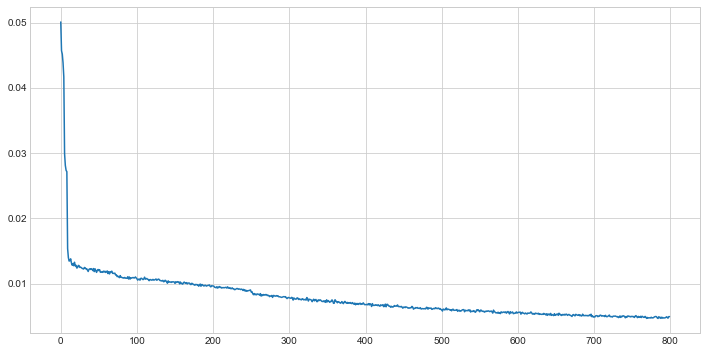

In [22]:
plt.figure(figsize=(12,6))
plt.plot(loss_graph)
plt.show()

## __Test__

In [23]:
test_loss_list = []
epoch_loss = 0

predlist = []

model.eval()
with torch.no_grad():
    for x, y_true in testloader:

        y_pred = model(x)
        kane = y_pred.flatten().cpu().tolist()
        predlist += kane

        loss = criterion(y_pred, y_true)

        epoch_loss += loss.item()
    
    test_loss_list.append(epoch_loss/n)

print(f'Loss:  {np.round(test_loss_list, 7)[0]}')


truelist = scaled_ytest[in_hours:] # (504, 1) --> (336, 1)
truelist = yscaler.inverse_transform(truelist)
truelist = truelist.ravel().tolist()
predlist = yscaler.inverse_transform(np.array(predlist).reshape(-1, 1))
predlist = predlist.tolist()

print()
print(f'len(predlist):  {len(predlist)}')
print(f'len(truelist):  {len(truelist)}')

Loss:  4.71e-05

len(predlist):  336
len(truelist):  336


## __Results__

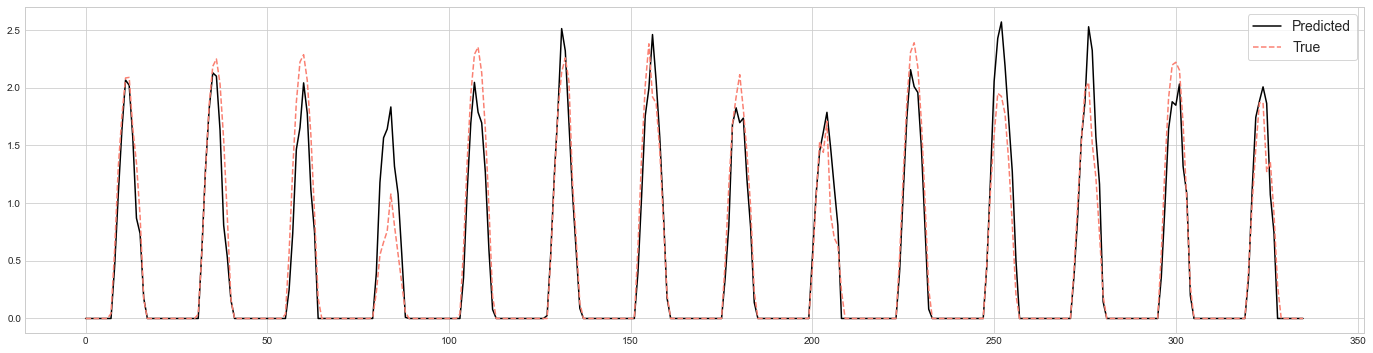

In [24]:
fig, ax = plt.subplots(1,1, figsize=(24, 6))


ax.plot(range(len(predlist)), predlist, color='black', label='Predicted')
ax.plot(range(len(predlist)), truelist, color='salmon', label='True', linestyle='dashed')

ax.legend(fontsize=14, frameon=True, )

plt.show()

## __End__